In [1]:
### Step-lenght
### sum of angles
### Number of spikes


In [1]:
from src.utile import *
from src.metrics import *
from src.visualisation import *

import numpy as np
import matplotlib.pyplot as plt
import time
import math
%load_ext autoreload
%autoreload 2
%load_ext line_profiler

In [3]:
cameras = get_camera_names()
days = get_days_in_order()
camera, day = cameras[0], days[0]
print(camera, day)
batches = csv_of_the_day(camera, day, drop_out_of_scope=True)

23520289 20210910_1550


In [4]:
csv_of_the_day('23520266', days[4], is_back=False)

[]

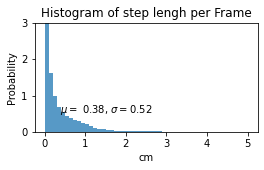

In [36]:
def activity_for_day_hist(fish_id, day_idx=1):
    camera_id, is_back = fish2camera[fish_id,0], fish2camera[fish_id,1]=="back"
    mu_sd = list()
    all_days = get_days_in_order()
    day = all_days[day_idx]
    df = pd.concat(csv_of_the_day(camera_id, day, is_back=is_back, drop_out_of_scope=True))
    c = calc_steps(df[["x", "y"]].to_numpy())
    p = plt.hist(c, bins=50,range=[0, 5], density=True, alpha=0.75)
    plt.ylim(0, 3)
    plt.xlabel('cm')
    plt.ylabel('Probability')
    plt.title('Histogram of step lengh per Frame')
    mu, om = np.mean(c), np.std(c)
    plt.text(mu, om, r'$\mu=\ $'+ "%.2f, "%mu + r'$\sigma=$'+"%.2f"%om)
    plt.show()

datah = activity_for_day_hist(2)


In [44]:
df0ang = turning_angle_per_interval(0, 100, [0,0.5])

FISH: ['23520289' 'front']
From day 0  to day 14 out of 29 days


In [8]:
df0 = activity_per_interval(0, 100, [0,0.5])

FISH: ['23520289' 'front']
From day 0  to day 14 out of 29 days


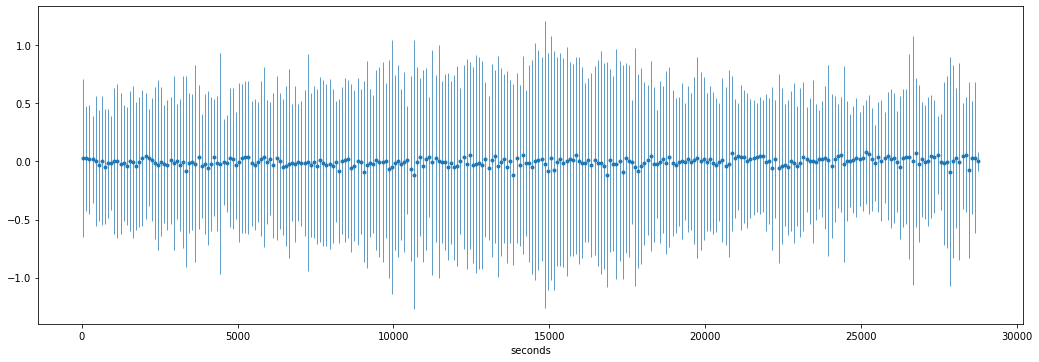

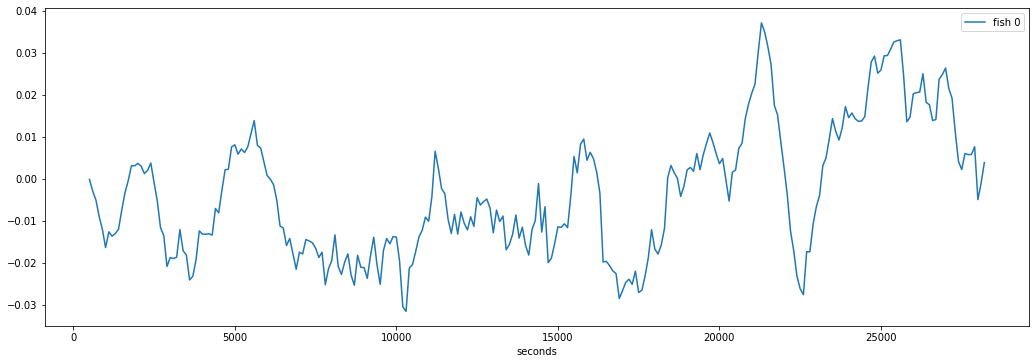

In [30]:
f = plot_turning_direction(df0ang[1], 100)
fs = sliding_window(df0ang[1], 100, 10)
### back and front 

In [10]:
#df1 = activity_per_interval(1, 100, [0,0.3])
range_fish=list(range(0,24))
dfs = [activity_per_interval(f, 100, [0,0.2])[2] for f in range_fish]

FISH: ['23520289' 'front']
From day 0  to day 5 out of 29 days
FISH: ['23520289' 'back']
From day 0  to day 5 out of 29 days
FISH: ['23484201' 'front']
From day 0  to day 5 out of 29 days
FISH: ['23484201' 'back']
From day 0  to day 5 out of 29 days
FISH: ['23520258' 'front']
From day 0  to day 5 out of 29 days
FISH: ['23520258' 'back']
From day 0  to day 5 out of 29 days
FISH: ['23442333' 'front']
From day 0  to day 5 out of 29 days
FISH: ['23442333' 'back']
From day 0  to day 5 out of 29 days
FISH: ['23520268' 'front']
From day 0  to day 5 out of 29 days
FISH: ['23520268' 'back']
From day 0  to day 5 out of 29 days
FISH: ['23520257' 'front']
From day 0  to day 5 out of 29 days
FISH: ['23520257' 'back']
From day 0  to day 5 out of 29 days
FISH: ['23520266' 'front']
From day 0  to day 5 out of 29 days
FISH: ['23520266' 'back']
From day 0  to day 5 out of 29 days
FISH: ['23484204' 'front']
From day 0  to day 5 out of 29 days
FISH: ['23484204' 'back']
From day 0  to day 5 out of 29 days


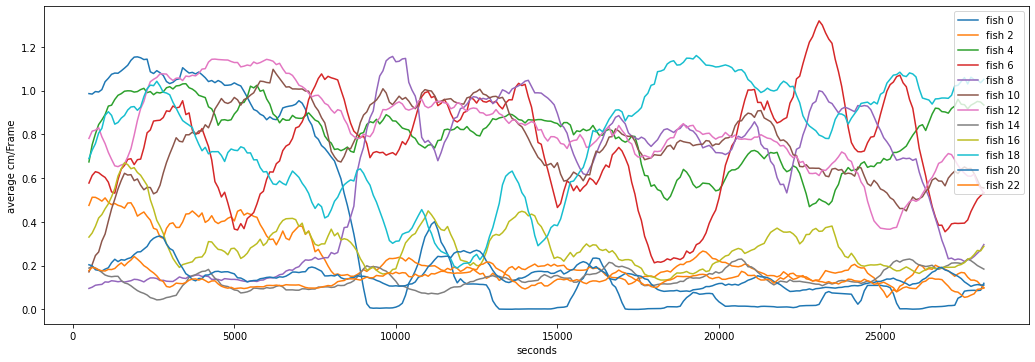

In [32]:
f = sliding_window(dfs[0::2], 100, 10, fish_ids=range_fish[0::2])

In [211]:
e[2].shape

(11,)

FISH: ['23520289' 'front']
4.57613784439655 (20, 10)


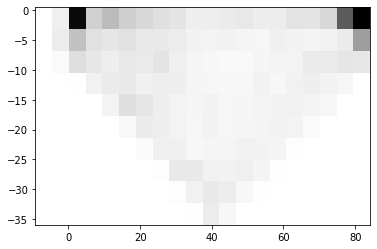

In [244]:
from scipy.stats import entropy
import seaborn as sns

def entropy_for_day(fish_id, day_idx=0):
    camera_id, is_back = fish2camera[fish_id,0], fish2camera[fish_id,0]=="back"
    print("FISH:", fish2camera[fish_id])
    all_days = get_days_in_order()
    day = all_days[day_idx]
    df = pd.concat(csv_of_the_day(camera_id, day, is_back=is_back))
    data = df[["x", "y"]].to_numpy()
    h = plt.hist2d(data[:,0],data[:,1], bins=(20, 10), cmap=plt.cm.Greys, density=True)
    #h = sns.kdeplot(x=data[:,0],y=data[:,1], cmap="Reds", shade=True, bw_adjust=.5, gridsize=50)
    print(entropy(h[0].ravel()), h[0].shape)
    #plt.show()
    return h

def entropy_from_2dhist(data, x, y):
    prob = list()
    xc = 80/len(x)
    yc = 40/len(y)
    l_x,l_y = data.shape
    offset=20
    for j in range(0, l_y):
        for i in range(max(j-offset,1), min(l_x, l_x-j+offset)):
            prob.append(data[i,l_y-1-j])
    return entropy(prob), np.std(prob)*100


e = entropy_for_day(0, 9)
entropy_value = entropy_from_2dhist(*e[:3])

In [245]:
entropy_value

(4.575169540188712, 0.041621686453052906)

In [61]:
s = e[0].ravel().size
z = np.ones(s)
entropy(z)

5.298317366548037

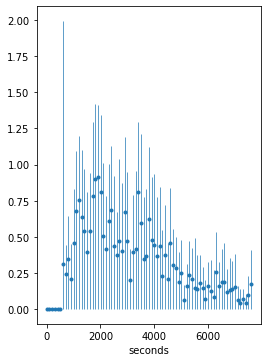

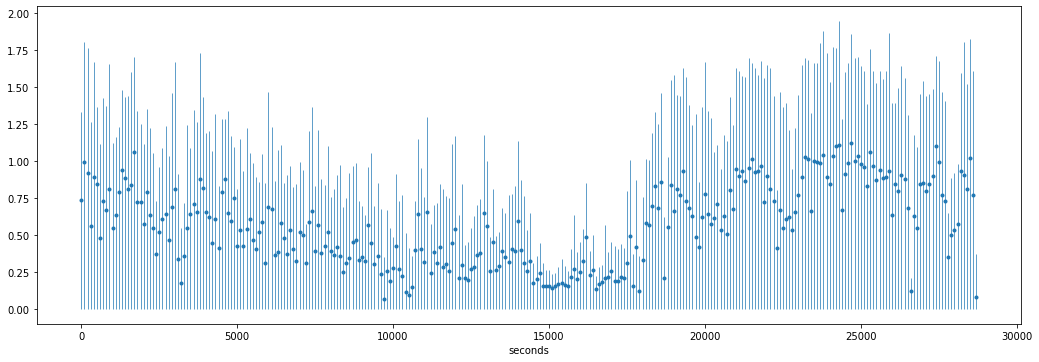

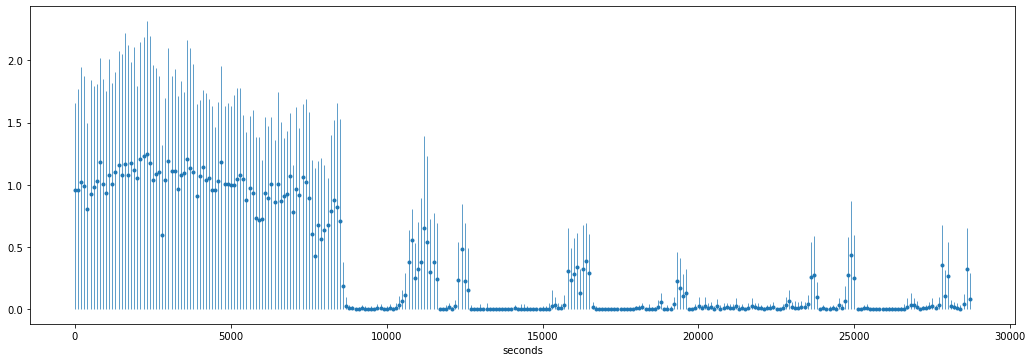

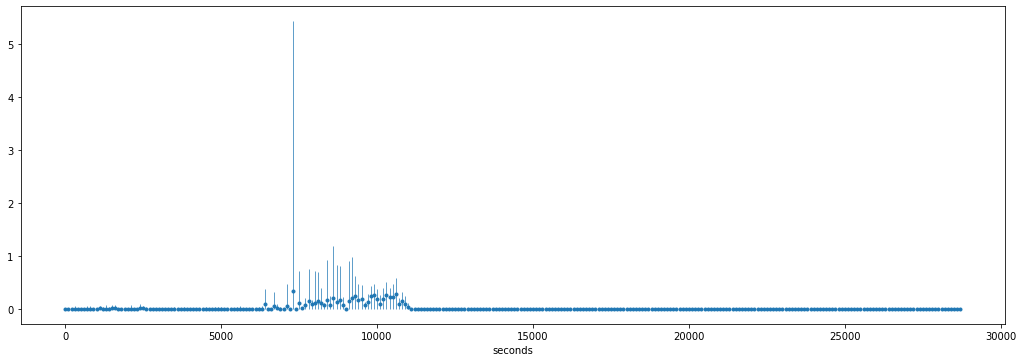

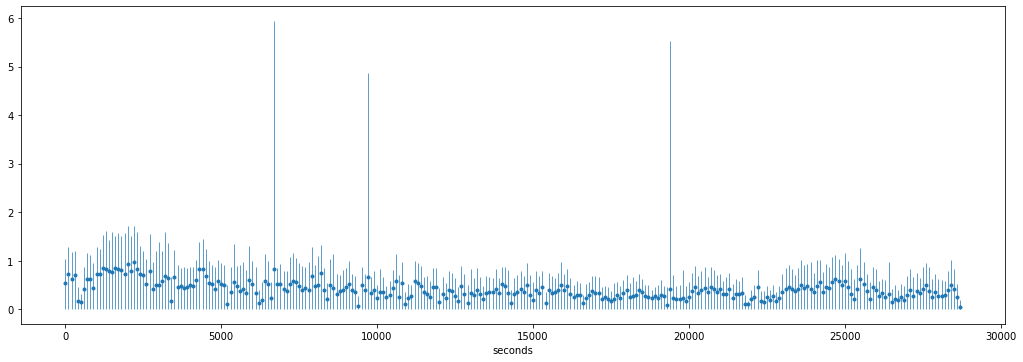

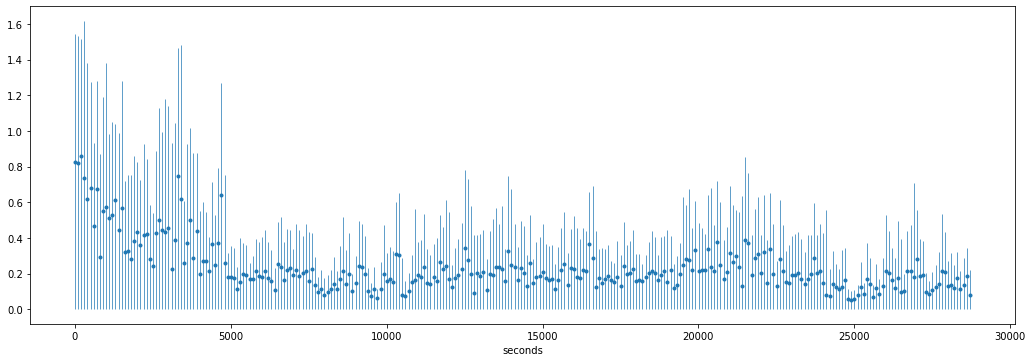

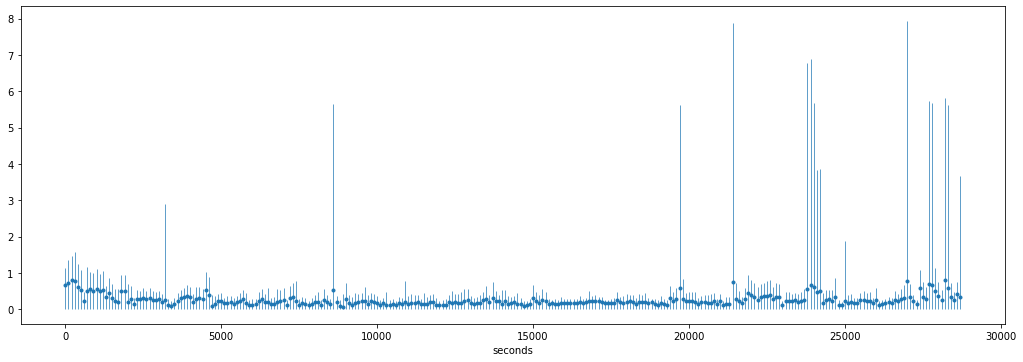

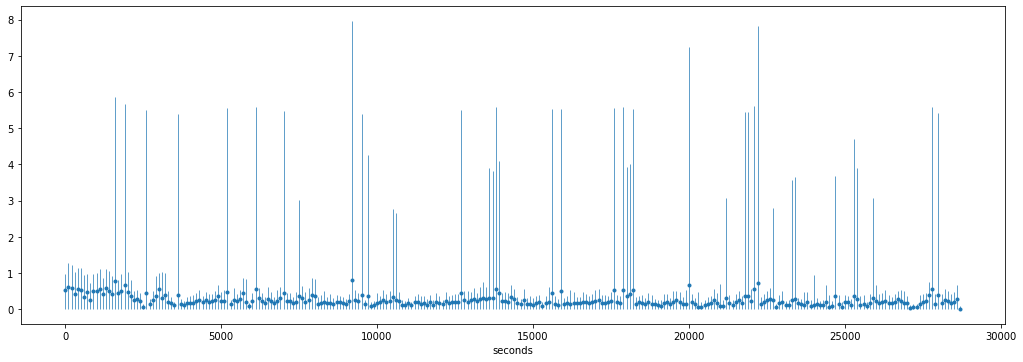

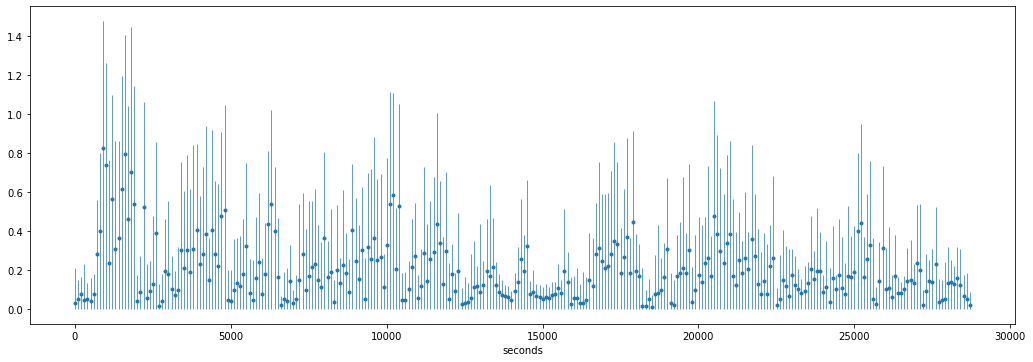

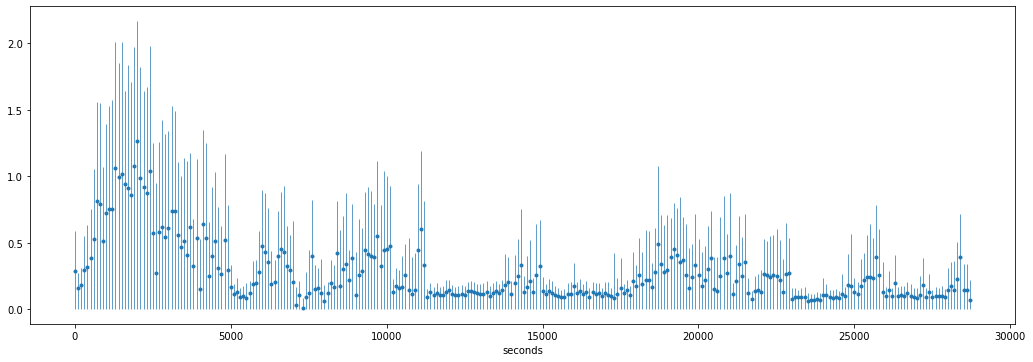

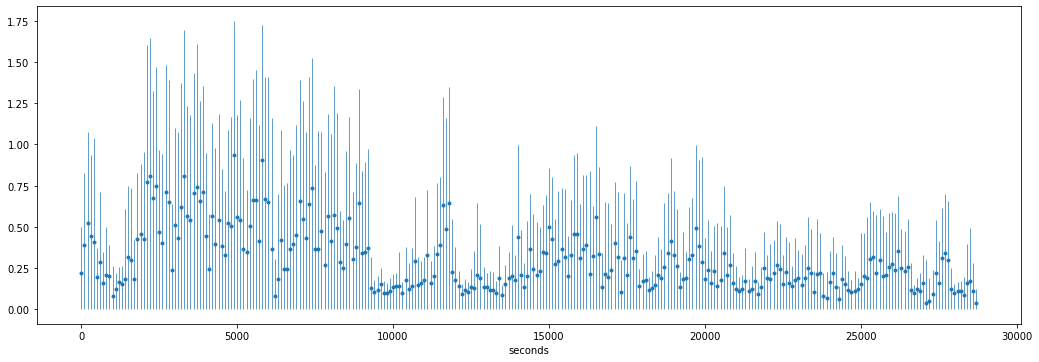

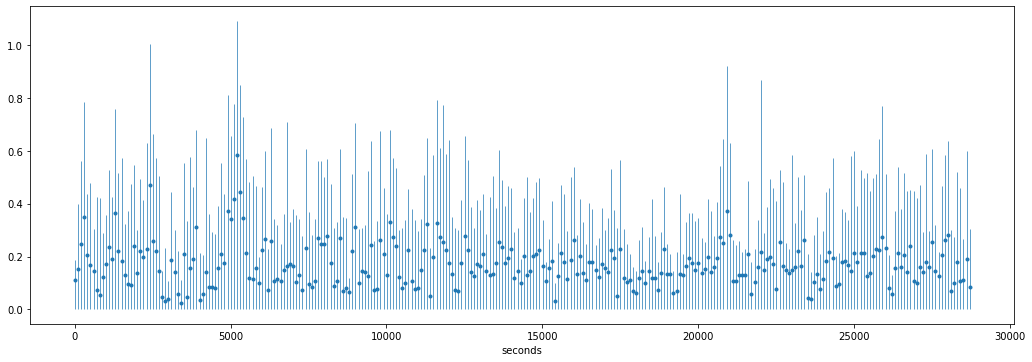

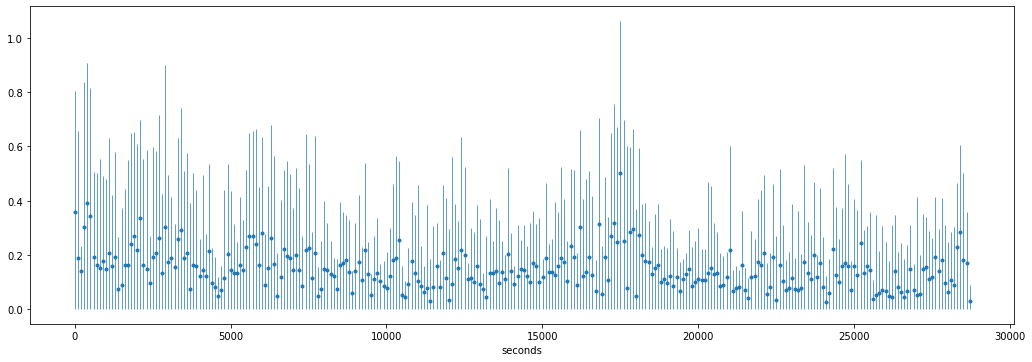

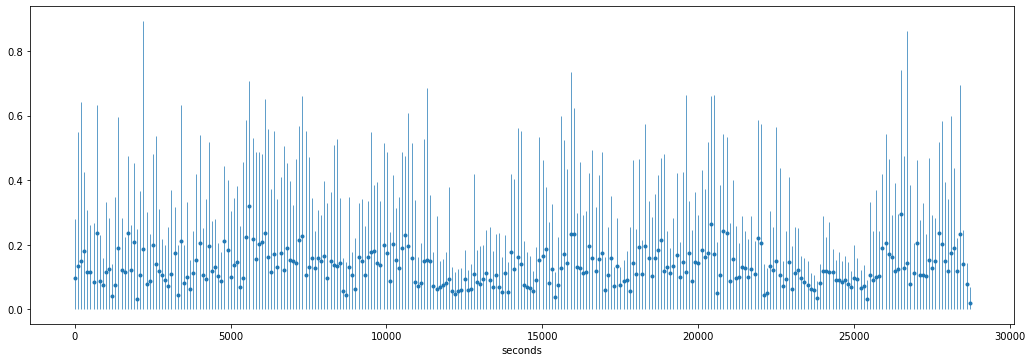

In [86]:
for d in df0:
    fig = plot_activity(d, 100)